In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import warnings

warnings.filterwarnings("ignore")

In [89]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Download and load data

In [103]:
dt = stock_data("INTC")

In [104]:
dt.get_daily("full")

,open,high,low,close,volume
date,,,,,
2024-11-29,23.69,24.280,23.60,24.05,36616750.0
2024-11-27,23.83,23.930,23.06,23.65,53992319.0
2024-11-26,24.95,24.985,23.81,24.05,69613557.0
2024-11-25,25.04,25.565,24.76,24.87,91128387.0
2024-11-22,24.35,24.680,24.14,24.50,36784715.0
...,...,...,...,...,...
1999-11-05,82.38,83.880,81.81,82.38,19837200.0
1999-11-04,80.44,81.750,80.19,81.56,21843500.0
1999-11-03,78.38,80.690,77.75,79.75,25240100.0


In [105]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [115]:
dt.insert_table(con, if_exists ="replace")

Data for INTC inserted into database


In [116]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('IBM',), ('TSLA',), ('INTC',)]


In [108]:
sql = "SELECT * FROM IBM"

In [109]:
df_IBM = pd.read_sql(sql, con, parse_dates="data", index_col="date")

In [110]:
df_IBM.head()

,open,high,low,close,volume
date,,,,,
2024-11-18T00:00:00,207.00,208.4150,205.3701,208.09,3406045.0
2024-11-15T00:00:00,207.46,208.4900,204.0700,204.99,3986460.0
2024-11-14T00:00:00,210.00,210.4999,206.3500,208.99,6372853.0
2024-11-13T00:00:00,209.50,211.4100,209.0701,210.92,3247830.0
2024-11-12T00:00:00,211.90,213.0300,209.0600,210.86,2818216.0


In [111]:
df_IBM.index = pd.to_datetime(df_IBM.index, format='ISO8601')

In [112]:
df_IBM.head()

,open,high,low,close,volume
date,,,,,
2024-11-18,207.00,208.4150,205.3701,208.09,3406045.0
2024-11-15,207.46,208.4900,204.0700,204.99,3986460.0
2024-11-14,210.00,210.4999,206.3500,208.99,6372853.0
2024-11-13,209.50,211.4100,209.0701,210.92,3247830.0
2024-11-12,211.90,213.0300,209.0600,210.86,2818216.0


In [113]:
df_IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6303 entries, 2024-11-18 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6303 non-null   float64
 1   high    6303 non-null   float64
 2   low     6303 non-null   float64
 3   close   6303 non-null   float64
 4   volume  6303 non-null   float64
dtypes: float64(5)
memory usage: 295.5 KB


In [15]:
df_IBM.sort_index(inplace=True)

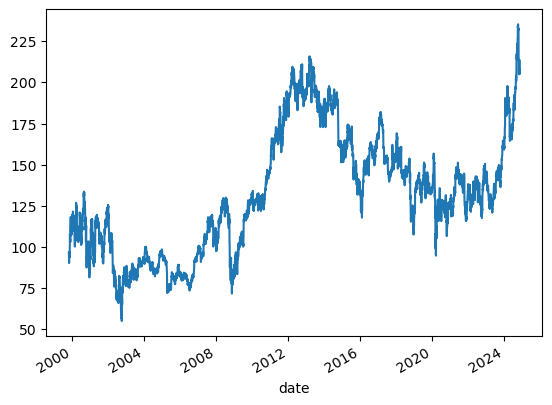

In [16]:
df_IBM['close'].plot();

# Calculate Returns

In [17]:
df_IBM['returns'] = np.log(df_IBM['close'] / df_IBM['close'].shift(1))*100
# df_IBM['returns'] = df_IBM["close"].pct_change()*100

In [18]:
df_IBM["close"]

date
1999-11-01     96.75
1999-11-02     94.81
1999-11-03     94.37
1999-11-04     91.56
1999-11-05     90.25
               ...  
2024-11-12    210.86
2024-11-13    210.92
2024-11-14    208.99
2024-11-15    204.99
2024-11-18    208.09
Name: close, Length: 6303, dtype: float64

In [19]:
df_IBM["returns"]

date
1999-11-01         NaN
1999-11-02   -2.025544
1999-11-03   -0.465166
1999-11-04   -3.022873
1999-11-05   -1.441090
                ...   
2024-11-12   -1.277024
2024-11-13    0.028451
2024-11-14   -0.919251
2024-11-15   -1.932521
2024-11-18    1.500948
Name: returns, Length: 6303, dtype: float64

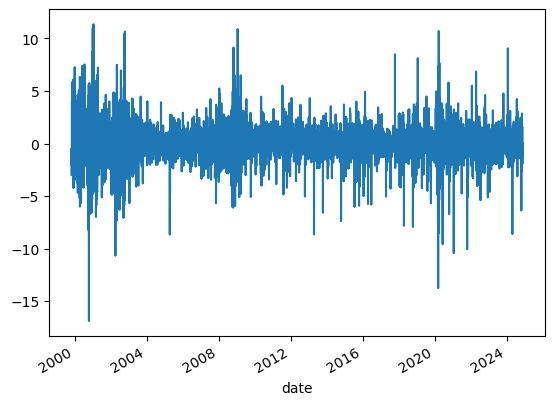

In [20]:
df_IBM["returns"].dropna().plot();

In [21]:
vol=df_IBM["returns"].rolling(30).std().dropna()

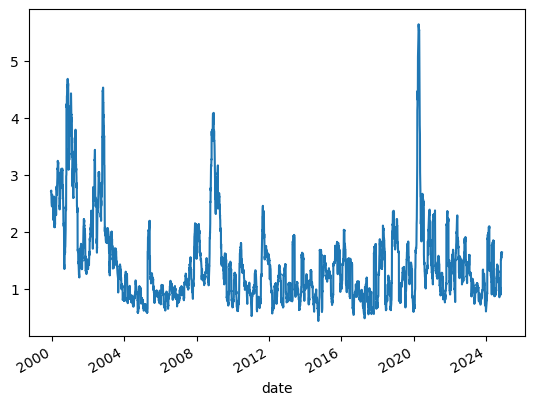

In [22]:
(vol).plot();

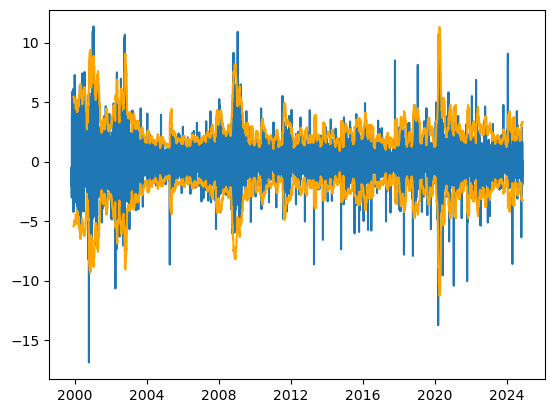

In [23]:
plt.plot(df_IBM["returns"].dropna())
plt.plot(2*vol, color="orange" )
plt.plot(-2*vol, color="orange" )

# Train test split

In [24]:
y = df_IBM["returns"].dropna()
cutoff = int(0.8*len(y))

In [25]:
y_train = y.iloc[:cutoff]
y_train

date
1999-11-02   -2.025544
1999-11-03   -0.465166
1999-11-04   -3.022873
1999-11-05   -1.441090
1999-11-08    4.007268
                ...   
2019-11-07   -0.788516
2019-11-08   -0.058118
2019-11-11   -1.567338
2019-11-12    0.088541
2019-11-13   -0.822014
Name: returns, Length: 5041, dtype: float64

In [26]:
y_test = y.iloc[cutoff:]
y_test

date
2019-11-14   -0.357569
2019-11-15    0.298063
2019-11-18   -0.066987
2019-11-19    0.156233
2019-11-20   -0.986113
                ...   
2024-11-12   -1.277024
2024-11-13    0.028451
2024-11-14   -0.919251
2024-11-15   -1.932521
2024-11-18    1.500948
Name: returns, Length: 1261, dtype: float64

# GARCH model prediction

In [27]:
model = arch_model(y_train,p=1,q=1)

In [28]:
res = model.fit(disp=0)

In [29]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8868.89
Distribution:                  Normal   AIC:                           17745.8
Method:            Maximum Likelihood   BIC:                           17771.9
                                        No. Observations:                 5041
Date:                Fri, Nov 29 2024   Df Residuals:                     5040
Time:                        11:11:37   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0303  1.915e-02      1.582      0.114 

In [30]:
h_size= y_test.shape[0]

In [31]:
forecasts = res.forecast(horizon=h_size)
pred_vol = (forecasts.variance.values[0])**0.5
pred_vol

array([1.22548913, 1.23911049, 1.25213914, ..., 1.58552637, 1.58552637,
       1.58552637])

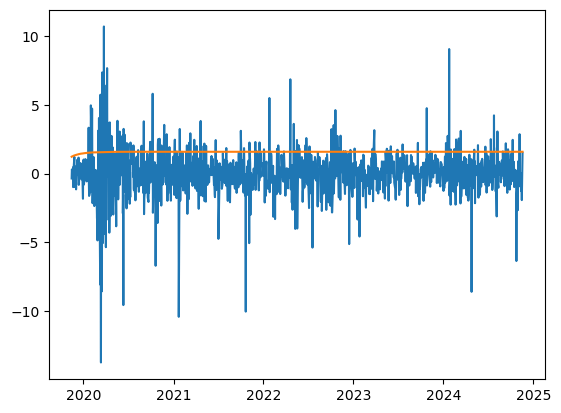

In [32]:
plt.plot(df_IBM["returns"].iloc[-len(y_test):])
plt.plot(y_test.index[:h_size],pred_vol);

# GARCH model walk forward prediction

In [33]:
w_fwd_pred=[]

for i in range(y_test.shape[0]):
    y_train = df_IBM["returns"].iloc[1:-(y_test.shape[0]-i)]
    model = arch_model(y_train, p=1, q=1, rescale=False)
    res= model.fit(disp=0)
    forecasts = res.forecast(horizon=1)
    pred_vol = (forecasts.variance.values[-1,:][0])**0.5
    w_fwd_pred.append(pred_vol)
    

In [34]:
w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index)

In [35]:
window=21
test_vol = df_IBM["returns"].rolling(window).std().dropna()

In [36]:
test_vol = test_vol.iloc[-y_test.shape[0]:]

In [37]:
len(test_vol)

1261

In [38]:
len(w_fwd_vol)

1261

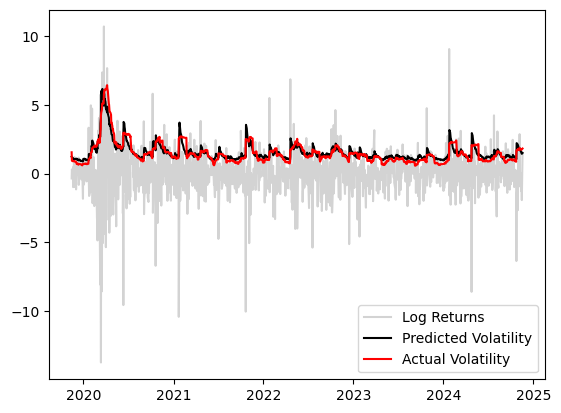

In [39]:
plt.plot(df_IBM["returns"].iloc[-len(y_test):], color="lightgray", label="Log Returns")
plt.plot(w_fwd_vol, color="black", label="Predicted Volatility")
plt.plot(test_vol, color="red", label="Actual Volatility")
plt.legend();

In [75]:
R2 = r2_score(test_vol, w_fwd_vol)
round(R2,2)

0.82

In [74]:
MAE = mean_absolute_error(test_vol, w_fwd_vol)
round(MAE,2)

0.26

In [76]:
MSE = mean_squared_error(test_vol, w_fwd_vol)
round(MSE,2)

0.12

# Simple LSTM model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [45]:
df_IBM

,open,high,low,close,volume,returns
date,,,,,,
1999-11-01,98.50,98.8100,96.3700,96.75,9551800.0,NaN
1999-11-02,96.75,96.8100,93.6900,94.81,11105400.0,-2.025544
1999-11-03,95.87,95.9400,93.5000,94.37,10369100.0,-0.465166
1999-11-04,94.44,94.4400,90.0000,91.56,16697600.0,-3.022873
1999-11-05,92.75,92.9400,90.1900,90.25,13737600.0,-1.441090
...,...,...,...,...,...,...
2024-11-12,211.90,213.0300,209.0600,210.86,2818216.0,-1.277024
2024-11-13,209.50,211.4100,209.0701,210.92,3247830.0,0.028451
2024-11-14,210.00,210.4999,206.3500,208.99,6372853.0,-0.919251


In [46]:
df_IBM["rolling_volatility"] = df_IBM["returns"].rolling(window=21).std()

In [47]:
df_IBM.dropna(inplace=True)

In [48]:
df_IBM.head()

,open,high,low,close,volume,returns,rolling_volatility
date,,,,,,,
1999-12-01,102.56,104.44,102.25,103.42,5336400.0,0.348702,2.524261
1999-12-02,103.44,106.31,103.37,105.27,6216900.0,1.773011,2.483744
1999-12-03,109.81,112.87,107.94,111.87,14680300.0,6.080900,2.752959
1999-12-06,113.00,116.50,112.50,116.00,9928300.0,3.625271,2.671188
1999-12-07,117.00,119.19,115.44,116.62,11326100.0,0.533059,2.610349


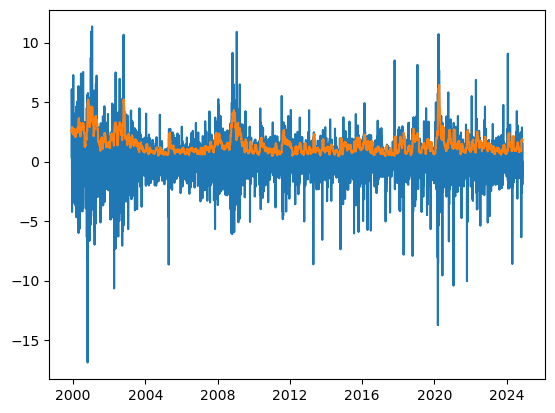

In [49]:
plt.plot(df_IBM['returns'])
plt.plot(df_IBM['rolling_volatility']);

## Train-test split

In [61]:
cut_off= int(len(df_IBM)*0.8)

In [62]:
target = ["rolling_volatility"]
X = df_IBM.drop(columns=target)
y=df_IBM[target]

In [63]:
X.head()

,open,high,low,close,volume,returns
date,,,,,,
1999-12-01,102.56,104.44,102.25,103.42,5336400.0,0.348702
1999-12-02,103.44,106.31,103.37,105.27,6216900.0,1.773011
1999-12-03,109.81,112.87,107.94,111.87,14680300.0,6.080900
1999-12-06,113.00,116.50,112.50,116.00,9928300.0,3.625271
1999-12-07,117.00,119.19,115.44,116.62,11326100.0,0.533059


In [64]:
y.head()

,rolling_volatility
date,
1999-12-01,2.524261
1999-12-02,2.483744
1999-12-03,2.752959
1999-12-06,2.671188
1999-12-07,2.610349


In [54]:
X_train=X[:cut_off]
y_train=y[:cut_off]

In [55]:
X_test=X[cut_off:]
y_test=y[cut_off:]

# Reshape Input for LSTM (introduce lag)

In [59]:
list(X.columns)

['open', 'high', 'low', 'close', 'volume', 'returns']

In [65]:
# Function to create LSTM dataset
def create_lstm_dataset(dataset, time_steps=7):
    features = dataset.columns
    
    # Normalize the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset[features])
    
    X, y = [], []
    
    # Create sliding window
    for i in range(len(scaled_data) - time_steps):
        # X: Input sequence of time_steps
        X.append(scaled_data[i:i+time_steps])
        
        # y: Next time step's closing price
        y.append(scaled_data[i+time_steps][-1])  # Predicting the next close price
    
    return np.array(X), np.array(y), scaler

In [66]:
# Generate training data
time_steps = 7
X_train, y_train, scaler = create_lstm_dataset(X, time_steps=time_steps)

In [68]:
# Get the number of features
data_dim = X_train.shape[2]
data_dim

6

In [69]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(time_steps, data_dim)),
    Dense(units=1)
])

In [70]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,  # Optional: use 20% of data for validation
    verbose=1
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0722 - val_loss: 0.0039
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 69/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 70/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 71/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 72/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 73/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 74/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 75/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 76/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 77/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 78/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 79/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 

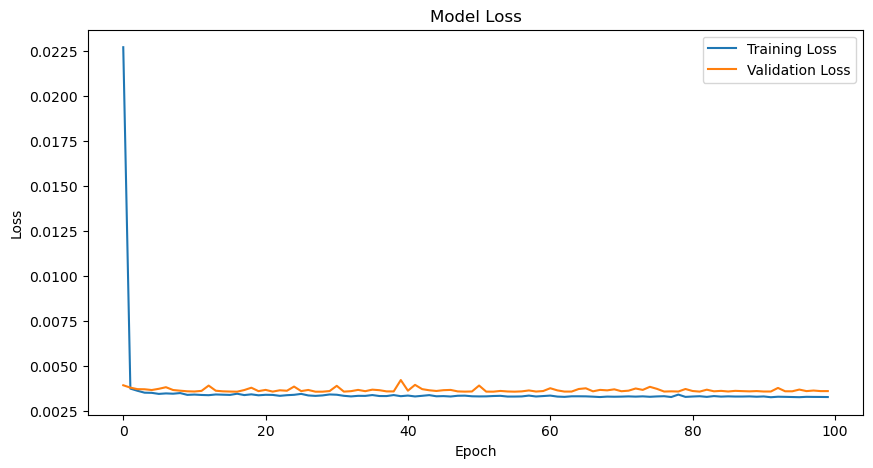

In [72]:
# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [83]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,355 (134.20 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,904 (89.47 KB)